Logistic Regression
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import math
from sklearn.svm import l1_min_c

In [ ]:

# methods to generate 2 dimension namely intensity and symmetry
def feature_intensity(raw_data):
    feature = np.zeros([len(raw_data),1])
    for i in range(len(raw_data)):
        feature[i] = np.mean(raw_data[i])
    return feature

def feature_symmetry(raw_data):
    feature = np.zeros([len(raw_data),1])
    for i in range(len(feature)):
        img = np.reshape(raw_data[i], [16,16])
        img_flip = np.fliplr(img)
        feature[i] = -np.linalg.norm(img-img_flip)
    return feature

def feature_extraction(raw_data):
    intensity = feature_intensity(raw_data)
    symmetry = feature_symmetry(raw_data)
    features = np.concatenate([np.ones([len(raw_data),1]), intensity, symmetry], axis=1)
    return features


In [ ]:
# Plot functions

def plot_grayscale(img_matrix):
    """
    Plot a matrix as a grayscale image.
    :param img_matrix: a matrix representing the density at each pixel
    :return: nothing.
    """
    plt.figure()
    plt.imshow(img_matrix, cmap=plt.cm.binary)
    plt.show()


def plot_2d(data, labels, title, model=None):
    """
    Positive class -- red x
    Negative class -- blue o
    :param plot_data:  [(x,y)]
    :return: nothing
    """

    plt.figure()

    # plot data.
    pos_data = data[labels == 1]
    neg_data = data[labels == -1]

    plt.plot(pos_data[:, 1], pos_data[:, 2], marker='x', mec='r', ls='', label='negative class')
    plt.plot(neg_data[:, 1], neg_data[:, 2], marker='o', mfc='none', mec='b', ls='', label='positive class')
    plt.plot()
    plt.xlabel("Intensity")
    plt.ylabel("Symmetry")
    plt.title(title)
    plt.legend()

    if model is not None:
        if model.size != 3:
            raise "Incorrect Dimension. 2D required. "

        # a function that computes x0 given a set of x1.
        get_x0 = lambda x_1: (-model[0] / model[2] - x_1 * model[1] / model[2]) \
            if model[0] != 0 else np.zeros(x_1.size)
        # formulate the line to plot
        x_min, x_max = plt.gca().get_xlim()
        line_x = np.linspace(x_min, x_max, 50)
        line_y = get_x0(line_x)

        plt.plot(line_x, line_y, linestyle='-', color='k')

    plt.show()
    

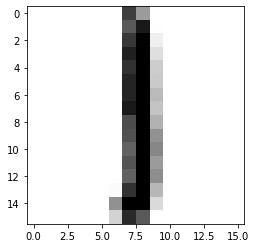

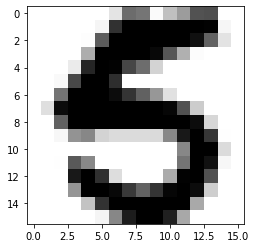

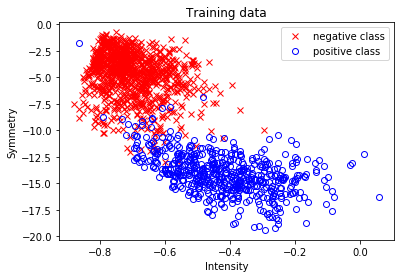

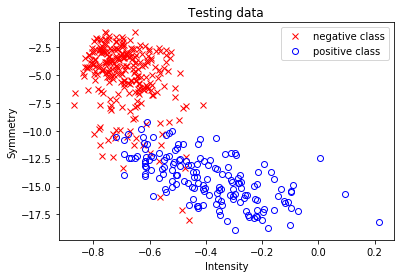

In [ ]:

# Load training data
train_data = np.load("train_data.npy")
train_labels = np.load("train_labels.npy")

# Load test data
test_data = np.load("test_data.npy")
test_labels = np.load("test_labels.npy")

# Plot train and test data as digit
plot_grayscale(np.reshape(train_data[0], [16, 16]))
plot_grayscale(np.reshape(train_data[1500], [16, 16]))

# Extract Features
train_features = feature_extraction(train_data)
test_features = feature_extraction(test_data)

# Plot train and test data 
plot_2d(train_features, train_labels, 'Training data')
plot_2d(test_features, test_labels, 'Testing data')


In [ ]:

def compute_objective_value(feature, target, model):
    obj_val = 0
    for i in range(len(target)):
        obj_val += np.log(1 + np.exp(-target[i] * np.dot(model, feature[i])))
    return obj_val/len(target)


def print_train_test_error(train_data, test_data, train_label, test_label, model):
    train_error = compute_objective_value(train_data, train_label, model)
    test_error = compute_objective_value(test_data, test_label, model)

    print("Train error: %f"%(train_error))
    print("Test error: %f"%(test_error))
  

Weights :  [ 5.83298873 -4.89307663  0.86590195]


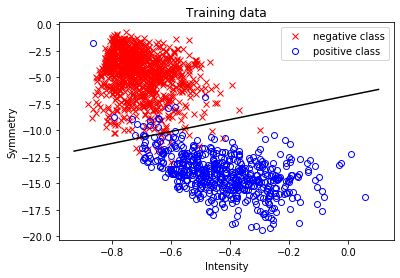

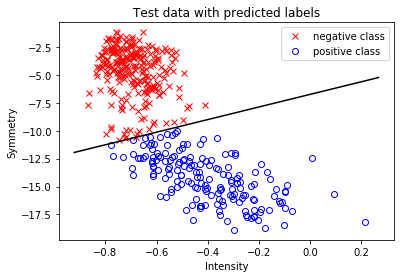

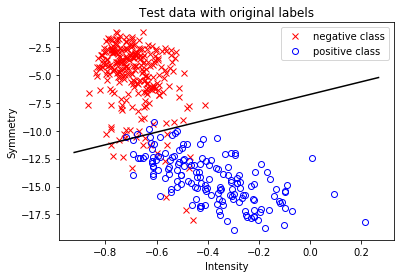

Train accuracy: 0.9762972453555413
Test accuracy: 0.9528301886792453
Train error: 0.073335
Test error: 0.152600


In [ ]:

# Define logistic regression model
log_res = LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
                                 C=1.0, fit_intercept=False, intercept_scaling=1, 
                                 class_weight=None, random_state=None, solver='liblinear', 
                                 max_iter=100, multi_class='ovr', verbose=0, 
                                 warm_start=False, n_jobs=None, l1_ratio=None)

# Fit training data to model and print
log_res.fit(train_features, train_labels)
weights = log_res.coef_[0]
print("Weights : " , weights)
plot_2d(train_features, train_labels, 'Training data', weights )

# Predict labels for test data
test_predict = log_res.predict(test_features)
plot_2d(test_features, test_predict, 'Test data with predicted labels', weights )
plot_2d(test_features, test_labels, 'Test data with original labels', weights )

train_score = log_res.score(train_features, train_labels)
test_score = log_res.score(test_features, test_labels)

print('Train accuracy: {}'.format(train_score))
print('Test accuracy: {}'.format(test_score))

print_train_test_error(train_features, test_features, train_labels, test_labels, weights)


In [ ]:
# L1 Regularization

coefficient_arr = l1_min_c(train_features, train_labels, loss='log') * np.logspace(0, 7, 16)
train_acc = []
test_acc = []
found_train_coefs = []
found_test_coefs = []

i = 0

for coeff in coefficient_arr:
    log_res.set_params(C=coeff, penalty="l1")
    log_res.fit(train_features, train_labels)
    #plot_2d(train_features, train_labels, 'Train data reqularization', log_res.coef_.ravel() )
    train_acc.append(log_res.score(train_features, train_labels))
    found_train_coefs.append(log_res.coef_.ravel().copy())
    
    log_res.fit(test_features, test_labels)
    #plot_2d(train_features, train_labels, 'Train data reqularization', log_res.coef_.ravel() )
    test_acc.append(log_res.score(test_features, test_labels))

    found_test_coefs.append(log_res.coef_.ravel().copy()) 
    i += 1

print("  | Accuracy Train \t| Accuracy Test \t| Difference \t\t| Coefficient")

for a in range(len(test_acc)):
    print(a, "", train_acc[a], "\t", test_acc[a], "\t", train_acc[a]-test_acc[a], "\t", found_train_coefs[a])




  | Accuracy Train 	| Accuracy Test 	| Difference 		| Coefficient
0  0.356181934657271 	 0.37735849056603776 	 -0.02117655590876677 	 [0. 0. 0.]
1  0.356181934657271 	 0.37735849056603776 	 -0.02117655590876677 	 [0.         0.         0.02865429]
2  0.957078795643818 	 0.37735849056603776 	 0.5797203050777803 	 [1.78505344 0.         0.20525439]
3  0.9673286354900704 	 0.9127358490566038 	 0.054592786433466656 	 [4.29287201 0.         0.44825922]
4  0.9762972453555413 	 0.9386792452830188 	 0.03761800007252247 	 [ 5.61523496 -1.42133075  0.65148029]
5  0.9769378603459321 	 0.9528301886792453 	 0.024107671666686814 	 [ 6.57369564 -3.27517428  0.84440072]
6  0.9762972453555413 	 0.9575471698113207 	 0.01875007554422059 	 [ 7.71272531 -4.43114456  1.01654851]
7  0.9769378603459321 	 0.9551886792452831 	 0.02174918110064905 	 [ 8.33310872 -5.1623398   1.11622478]
8  0.9775784753363229 	 0.9575471698113207 	 0.020031305525002208 	 [ 8.76811047 -5.35727834  1.1681752 ]
9  0.9775784753363229

For L1 regularization : Minimum difference between accuracy values of test data and train data is 0.020031305525002208 so after 8th iteration



In [ ]:
# L2 Regularization

coefficient_arr = l1_min_c(train_features, train_labels, loss='log') * np.logspace(0, 7, 16)
train_acc = []
test_acc = []
found_train_coefs = []
found_test_coefs = []

i = 0

for coeff in coefficient_arr:
    log_res.set_params(C=coeff, penalty="l2")
    log_res.fit(train_features, train_labels)
    #plot_2d(train_features, train_labels, 'Train data reqularization', log_res.coef_.ravel() )
    train_acc.append(log_res.score(train_features, train_labels))
    found_train_coefs.append(log_res.coef_.ravel().copy())
    
    log_res.fit(test_features, test_labels)
    #plot_2d(train_features, train_labels, 'Train data reqularization', log_res.coef_.ravel() )
    test_acc.append(log_res.score(test_features, test_labels))

    found_test_coefs.append(log_res.coef_.ravel().copy()) 
    i += 1

print("   | Accuracy Train \t| Accuracy Test \t| Difference \t\t| Coefficient")

for a in range(len(test_acc)):
    print(a, "", train_acc[a], "\t", test_acc[a], "\t", train_acc[a]-test_acc[a], "\t", found_train_coefs[a])



   | Accuracy Train 	| Accuracy Test 	| Difference 		| Coefficient
0  0.7418321588725176 	 0.41745283018867924 	 0.3243793286838384 	 [ 0.20868603 -0.17953055  0.06898457]
1  0.905829596412556 	 0.6674528301886793 	 0.2383767662238767 	 [ 0.51711483 -0.44335315  0.11244581]
2  0.9609224855861627 	 0.875 	 0.08592248558616267 	 [ 1.06244665 -0.91173423  0.18927442]
3  0.9698910954516335 	 0.9198113207547169 	 0.0500797746969166 	 [ 1.80836251 -1.55700511  0.29604666]
4  0.974375400384369 	 0.9433962264150944 	 0.03097917396927463 	 [ 2.70082482 -2.3360664   0.42494896]
5  0.9756566303651505 	 0.9528301886792453 	 0.022826441685905197 	 [ 3.72295727 -3.22667377  0.57234475]
6  0.9769378603459321 	 0.9528301886792453 	 0.024107671666686814 	 [ 4.86164003 -4.17743486  0.73378867]
7  0.9769378603459321 	 0.9504716981132075 	 0.026466162232724577 	 [ 6.05791543 -5.03746603  0.89527135]
8  0.9762972453555413 	 0.9481132075471698 	 0.02818403780837153 	 [ 7.17685648 -5.57545554  1.03107931]
9 

For L2 regularization : Minimum difference between accuracy values of test data and train data is 0.020031305525002208 so after 12th iteration

So, we could reach a converged model with coefficients after 8th iteration of L1 regularization or after 12th iteration of L2 regularization. Both of them could be used. 

At the end, we increase the accuracy from  0.9762972453555413 to 0.9775784753363229 via regularization.




Before Regularization


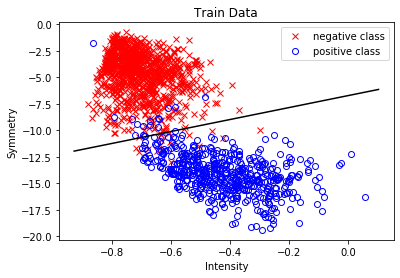


After Regularization


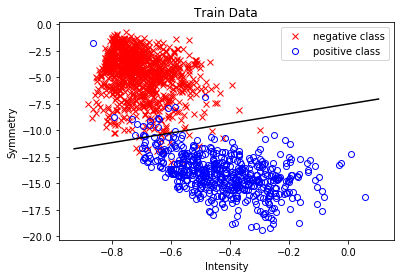

In [ ]:
print("\nBefore Regularization")

plot_2d(train_features, train_labels, 'Train Data', weights )


print("\nAfter Regularization")

plot_2d(train_features, train_labels, 'Train Data', found_train_coefs[15] )
